### Import the necessary packages
* matplotlib.pyplot for plotting
* [`OrderedDict`](https://docs.python.org/2/library/collections.html#ordereddict-objects) from collections: "Ordered dictionaries are just like regular dictionaries but they remember the order that items were inserted. When iterating over an ordered dictionary, the items are returned in the order their keys were first added."
* [`torch.nn`](https://pytorch.org/docs/stable/nn.html) for building the neuronal network
* [`torch.nn.optim`](https://pytorch.org/docs/stable/optim.html) to use the optimizer algorithms like SGD or Adam to update the weights.
* [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html#) for the neuronal network functions like activation functions, dropout functions etc.
* [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html) to get different datasets like MNIST, FASHION MINIST, CIFAR etc. 
* [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) to get different neuronal network models like AlexNet, VGG, DensNet, etc.
* [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) for image transformation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
import helper

Get the device. The device is either cuda:0 for GPU or CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Get the data
Get the `MNIST` dataset divided into the trainset and the testset! 

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ),(0.5,))])

trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

See one of the images.

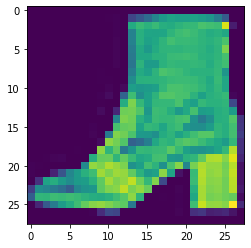

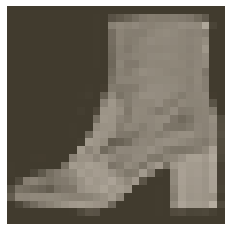

In [4]:
image, label = next(iter(trainloader))
# print(image[0].shape)
a = image[0].numpy()
# print(a)
# print(a[0].shape)
plt.imshow(a[0])
helper.imshow(image[0, :]);

### Build the network
There are two possible ways to build a network: 1. a static one 2. a dynamic one. 

**Within this notebook we build the static one with nn.Sequential()** 
```python
nn.Sequential(OrderedDict([]))
```

In [5]:
# define the hyperparameter
inpot_layer_size = 784
hidden_layer_size = [800, 400, 200, 100, 50]
output_layer_size= 10

netmodel = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(inpot_layer_size, hidden_layer_size[0])),
    ('relu1', nn.ReLU()),
    ('fcl2', nn.Linear(hidden_layer_size[0], hidden_layer_size[1])),
    ('relu2', nn.ReLU()),
    ('fcl3', nn.Linear(hidden_layer_size[1], hidden_layer_size[2])),
    ('relu3', nn.ReLU()),
    ('fcl4', nn.Linear(hidden_layer_size[2], hidden_layer_size[3])),
    ('relu4', nn.ReLU()),
    ('fcl5', nn.Linear(hidden_layer_size[3], hidden_layer_size[4])),
    ('relu5', nn.ReLU()),
    ('outlayer', nn.Linear(hidden_layer_size[4], output_layer_size))
]))

netmodel

Sequential(
  (fcl1): Linear(in_features=784, out_features=800, bias=True)
  (relu1): ReLU()
  (fcl2): Linear(in_features=800, out_features=400, bias=True)
  (relu2): ReLU()
  (fcl3): Linear(in_features=400, out_features=200, bias=True)
  (relu3): ReLU()
  (fcl4): Linear(in_features=200, out_features=100, bias=True)
  (relu4): ReLU()
  (fcl5): Linear(in_features=100, out_features=50, bias=True)
  (relu5): ReLU()
  (outlayer): Linear(in_features=50, out_features=10, bias=True)
)

Function for validating the model

In [6]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    # move the model to device ( this con be either the CPU or the GPU)
    model.to(device)
    
    for images, labels in testloader:
        # flatten the image into a 784 (28x28) element vector
        images.resize_(images.shape[0], 784)
        
         # move the torch tensors images and labels to device
        images, labels = images.to(device), labels.to(device)
        
        # forward pass through the network
        output = model.forward(images)
        
        # calculate the loss / error between the output and the true labels to accumulate the loss / cost
        # loss is a scalar tensor therefore .item() is needed to get the value out of the tensor
        test_loss += criterion(output, labels).item()
        
#         loss = criterion(output, labels)
#         lest_loss += loss.item()

        # calculate the probability distribution using the softmax function
        ps = F.softmax(output, dim=1)
        
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

### Train the model
Make a single cycle consisting of:
1. **Definition of the loss function**. This is needed to calculate the loss / difference between the result of the forward pass through the network and the true value (=label) -> `criterion = nn.CrossEntropyLoss()`
2. **Definition of the optimizer function**. The optimizer function updates the defined parameters (=weights of the network) -> `optimizer = optim.Adam(netmodel.parameters(), lr=0.01)`
* **Move the model to device** ( this is either the CPU or the GPU) -> `netmodel.to(device)`
* **Get the images and the corresponding labels** -> `images, labels = next(iter(trainloader))`
* **Flatten the images** into an element vector -> `images.resize_(images.size()[0], 784)`
* **Move the torch tensors *images* and *labels* to device** (this is either the CPU or the GPU) -> `images, labels = images.to(device), labels.to(device)`
* **Clear the gradients**. This is necessary because the gradients are accumulated during the backward pass. -> `optimizer.zero_grad()`
* **Forward pass** through the network -> `output = netmodel.forward(images)`
* **Calculate the loss** -> `loss = criterion(output, labels)`
* **Backwards pass** to calculate the gradients  -> `loss.backward()`
* **Update the weights** -> `optimizer.step()`

Select the network - dynamic or static

In [7]:
# define the loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer and pass in the network parameters that should be optimized and the learning rate 
optimizer = optim.Adam(netmodel.parameters(), lr=0.003)

# set the number of epochs. One epoch is a pass through the entire dataset (= training set)
epochs = 4
# print everey 40 steps the averaged loss over these 40 steps
print_every = 40
steps = 0

# move the model to device ( this con be either the CPU or the GPU)
netmodel.to(device)

for e in range(epochs):
    # accumulate the loss
    running_loss = 0
    # iterate over the training set
    for images, labels in iter(trainloader):
        steps += 1
        
        # flatten the image into a 784 (28x28) element vector
        images.resize_(images.size()[0], 784)
        
        # move the torch tensors images and labels to device
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients, because backward accumulates the gradients and so they have to be cleared
        optimizer.zero_grad()

        # forward pass through the network
        output = netmodel.forward(images)

        # calculate the loss / error between the output and the true labels
        loss = criterion(output, labels)

        # calculate the gradients
        loss.backward()

        # update the weights
        optimizer.step()
        
        # accumulate the loss / cost
        # loss is a scalar tensor therefore .item() is needed to get the value out of the tensor
        running_loss += loss.item()
    

        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            # -> Turn OFF the dropout functionality in evaluation mode
            netmodel.eval()

            # Turn off gradient computation for validation, saves memory and computations
            with torch.no_grad():
                # call validation to validate the model
                test_loss, accuracy = validation(netmodel, testloader, criterion)

            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Training loss: {:.3f}".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

#                 running_loss = 0

            # Make sure training is back on
            # -> Turn ON dropout functionality in training mode
            netmodel.train()

            running_loss = 0
            

Epoch: 1/4...  Training loss: 1.354 Test Loss: 0.906..  Test Accuracy: 0.660
Epoch: 1/4...  Training loss: 0.887 Test Loss: 0.778..  Test Accuracy: 0.718
Epoch: 1/4...  Training loss: 0.726 Test Loss: 0.695..  Test Accuracy: 0.734
Epoch: 1/4...  Training loss: 0.684 Test Loss: 0.666..  Test Accuracy: 0.755
Epoch: 1/4...  Training loss: 0.680 Test Loss: 0.719..  Test Accuracy: 0.726
Epoch: 1/4...  Training loss: 0.593 Test Loss: 0.580..  Test Accuracy: 0.796
Epoch: 1/4...  Training loss: 0.613 Test Loss: 0.587..  Test Accuracy: 0.797
Epoch: 1/4...  Training loss: 0.555 Test Loss: 0.573..  Test Accuracy: 0.801
Epoch: 1/4...  Training loss: 0.586 Test Loss: 0.573..  Test Accuracy: 0.786
Epoch: 1/4...  Training loss: 0.548 Test Loss: 0.571..  Test Accuracy: 0.798
Epoch: 1/4...  Training loss: 0.488 Test Loss: 0.571..  Test Accuracy: 0.816
Epoch: 1/4...  Training loss: 0.505 Test Loss: 0.646..  Test Accuracy: 0.766
Epoch: 1/4...  Training loss: 0.511 Test Loss: 0.530..  Test Accuracy: 0.815

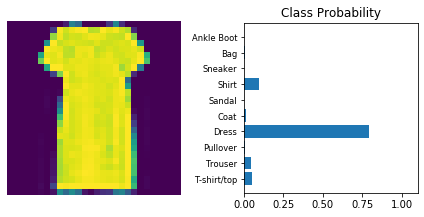

In [8]:
# Test out your network!
netmodel.to('cpu')

netmodel.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

with torch.no_grad():
    output = netmodel.forward(img)

# Calculate the class probabilities (softmax) for img
ps = F.softmax(output, dim=1)
# ps = F.softmax(netmodel.forward(img))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')